In [58]:
import os, math, json, pickle, argparse, random
from pathlib import Path
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

# ↓ Uses a small, fast sentence embedding model
from sentence_transformers import SentenceTransformer

In [59]:
import torch.optim as optim
import ast
import matplotlib.pyplot as plt


## Data Loading and Preprocessing

Load the dataset and perform necessary cleaning and feature engineering. This cleaned data will be used for both models.

In [60]:
import ast

uploaded_file_name = "/content/anime-dataset-2023.csv" # Replace with your actual file path if needed
print(f"Using default file path: {uploaded_file_name}")


df = pd.read_csv(uploaded_file_name)

print("Original DataFrame shape:", df.shape)




# -------------------------
# Utilities
# -------------------------

def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def save_pickle(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def load_pickle(path: Path):
    with open(path, "rb") as f:
        return pickle.load(f)


# --- Columns we want to KEEP (adjust if your CSV columns are different) ---
# Based on the previous successful execution, assuming the CSV has these columns
# Adjust these column names if your uploaded CSV has different headers
if 'anime_id' in df.columns: # Check if the new Kaggle dataset is used
    print("Using 'anime-dataset-2023.csv' structure.")
    keep_cols = [
        "Name",          # title
        "Genres",
        "Studios",
        "Episodes",
        "Synopsis",
        "Score",         # this becomes 'label'
    ]
    # Rename columns to match the model
    df = df[keep_cols].rename(columns={
        "Name": "title",
        "Genres": "genre",
        "Studios": "studio",
        "Episodes": "episodes",
        "Synopsis": "synopsis",
        "Score": "label"
    })

    # --- Handle missing / UNKNOWN values ---
    def clean_str(x):
        if pd.isna(x):
            return ""
        x = str(x).strip()
        # Adjust this list based on actual "unknown" representations in your data
        if x.upper() in ["N/A", "UNKNOWN", "NONE", "NULL", '?']:
            return ""
        return x

    df["title"] = df["title"].apply(clean_str)
    df["genre"] = df["genre"].apply(clean_str)
    df["studio"] = df["studio"].apply(clean_str)
    df["synopsis"] = df["synopsis"].apply(clean_str)

    # --- Parse genres / studios list-like text ---
    def parse_list(x):
        if pd.isna(x) or not x:
            return []
        try:
            # Attempt to parse with ast.literal_eval first (handles actual lists)
            val = ast.literal_eval(str(x))
            if isinstance(val, list):
                 # Ensure elements are strings and strip whitespace
                return [str(v).strip() for v in val if str(v).strip()]
        except (ValueError, SyntaxError):
             # Fallback for pipe or comma-separated strings
             # Handle potential leading/trailing spaces and empty tokens
            return [t.strip() for t in str(x).replace("|", ",").split(",") if t.strip()]
        return [] # Return empty list for any other unparseable cases


    df["genres_list"] = df["genre"].apply(parse_list) # Temporary column to parse list
    df["studios_list"] = df["studio"].apply(parse_list) # Temporary column to parse list

    # --- Pick only one studio (the first) ---
    df["studio"] = df["studios_list"].apply(lambda s: s[0] if len(s) else "Unknown")

    # --- Convert numeric columns ---
    df["episodes"] = pd.to_numeric(df["episodes"], errors="coerce").fillna(0)
    df["label"] = pd.to_numeric(df["label"], errors="coerce")

    # --- Drop rows with missing label (Score) or synopsis ---
    df = df.dropna(subset=["label", "synopsis", "title"]) # Also drop if title is missing
    df = df[df["label"] > 0]   # remove 0 or invalid scores

    # --- Simplify genres back into string form (pipe-separated) ---
    df["genre"] = df["genres_list"].apply(lambda lst: "|".join(lst) if lst else "Unknown")

    # --- Select final columns ---
    df_model = df[["title", "genre", "studio", "episodes", "synopsis", "label"]].copy()

    print("Cleaned DataFrame shape:", df_model.shape)
    print("Cleaned DataFrame head:")
    display(df_model.head())

else: # Assume the structure of the dataset from previous successful runs
    print("Using structure of the dataset from initial successful runs.")
    # --- Parse list-like columns ---
    def parse_list(x):
        # Check if the input is a scalar before calling pd.isna()
        if np.isscalar(x) and pd.isna(x):
            return []
        if isinstance(x, (list, np.ndarray)):
            # Convert list or array to a string representation that ast.literal_eval can handle
            x = str(x)
        if not isinstance(x, str):
            return []
        try:
            # Attempt to parse with ast.literal_eval first
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            # Fallback to splitting if ast.literal_eval fails
            return [i.strip() for i in x.strip("[]").split(",") if i.strip()]

    df["genres"]  = df["genres"].apply(parse_list)
    df["studios"] = df["studios"].apply(parse_list)

    # --- Basic cleanup ---
    df = df.dropna(subset=["title", "synopsis", "score"])  # remove missing core info
    df["episodes"] = pd.to_numeric(df["episodes"], errors="coerce").fillna(0)
    df["score"]    = pd.to_numeric(df["score"], errors="coerce").clip(0, 10)
    df["members"]  = pd.to_numeric(df["members"], errors="coerce").fillna(0)
    # df["year"]     = pd.to_numeric(df["year"], errors="coerce").fillna(0).astype(int) # 'year' not needed for model

    # --- Choose a single studio for now (first entry) ---
    df["studio"] = df["studios"].apply(lambda x: x[0] if len(x) else "Unknown")

    # --- Combine genres for easy use ---
    df["genre"] = df["genres"].apply(lambda x: "|".join(x) if x else "Unknown")

    # --- Keep the essential columns ---
    df_model = df[["title", "genre", "studio", "episodes", "synopsis", "score"]].rename(columns={"score": "label"})

    print("Cleaned DataFrame shape:", df_model.shape)
    print("Cleaned DataFrame head:")
    display(df_model.head())


# Split the data for training and validation
tr, va = train_test_split(df_model, test_size=0.15, random_state=1337)

# Fit encoders and scaler on the training set
genre_enc = MultiHotEncoder().fit(tr["genre"].fillna("").tolist())
studio_enc = CategoricalEncoder().fit(tr["studio"].fillna("").tolist())
scaler = StandardScaler().fit(tr["episodes"].fillna(0).astype(float).values.reshape(-1,1))

print("\nData preprocessing completed and encoders/scaler fitted on training data.")
print(f"Training set size: {len(tr)}")
print(f"Validation set size: {len(va)}")

# Save preprocessors
save_pickle({"genre_enc": genre_enc, "studio_enc": studio_enc, "scaler": scaler}, Path("artifacts") / "preprocessors.pkl")
print("✅ Saved preprocessors.")

Using default file path: /content/anime-dataset-2023.csv
Original DataFrame shape: (24905, 24)
Using 'anime-dataset-2023.csv' structure.
Cleaned DataFrame shape: (15692, 6)
Cleaned DataFrame head:


,title,genre,studio,episodes,synopsis,label
0,Cowboy Bebop,Action|Award Winning|Sci-Fi,Sunrise,26.0,"Crime is timeless. By the year 2071, humanity ...",8.75
1,Cowboy Bebop: Tengoku no Tobira,Action|Sci-Fi,Bones,1.0,"Another day, another bounty—such is the life o...",8.38
2,Trigun,Action|Adventure|Sci-Fi,Madhouse,26.0,"Vash the Stampede is the man with a $$60,000,0...",8.22
3,Witch Hunter Robin,Action|Drama|Mystery|Supernatural,Sunrise,26.0,Robin Sena is a powerful craft user drafted in...,7.25
4,Bouken Ou Beet,Adventure|Fantasy|Supernatural,Toei Animation,52.0,It is the dark century and the people are suff...,6.94



Data preprocessing completed and encoders/scaler fitted on training data.
Training set size: 13338
Validation set size: 2354
✅ Saved preprocessors.


In [62]:

# For Advanced Model
from transformers import DistilBertModel, DistilBertTokenizer

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for batch in loader:
        # Ensure the batch is moved to the correct device before using it
        batch_on_device = {k: v.to(device) for k, v in batch.items()}
        pred = model(batch_on_device)
        y_true.append(batch_on_device["y"].cpu().numpy())
        y_pred.append(pred.cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    try:
        rho, _ = spearmanr(y_true, y_pred)
        rho = float(rho) if not np.isnan(rho) else 0.0
    except ValueError: # Handle cases with constant arrays
        rho = 0.0
    return {"MAE": mae, "RMSE": rmse, "SpearmanR": rho}


# -------------------------
# Encoders for categorical & multi-hot
# -------------------------
class CategoricalEncoder:
    """Maps string categories to integer IDs with an OOV bucket."""
    def __init__(self):
        self.stoi: Dict[str, int] = {"<OOV>": 0}
        self.itos: List[str] = ["<OOV>"]

    def fit(self, values: List[str]):
        for v in values:
            if v not in self.stoi:
                self.stoi[v] = len(self.itos)
                self.itos.append(v)
        return self

    def transform(self, v: str) -> int:
        return self.stoi.get(v, 0)

    def __len__(self):
        return len(self.itos)


class MultiHotEncoder:
    """Multi-label encoder for pipe-separated strings like "Action|Comedy"."""
    def __init__(self):
        self.stoi: Dict[str, int] = {}
        self.itos: List[str] = []

    def fit(self, values: List[str]):
        for row in values:
            if pd.isna(row):
                continue
            for token in str(row).split("|"):
                token = token.strip()
                if token and token not in self.stoi:
                    self.stoi[token] = len(self.itos)
                    self.itos.append(token)
        return self

    def transform(self, row: str) -> np.ndarray:
        x = np.zeros(len(self.itos), dtype=np.float32)
        if pd.isna(row):
            return x
        for token in str(row).split("|"):
            token = token.strip()
            if token in self.stoi:
                x[self.stoi[token]] = 1.0
        return x

    def __len__(self):
        return len(self.itos)

# -------------------------
# Text embedding cache (for Baseline Model)
# -------------------------
class TextEmbedder:
    def __init__(self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2", cache_dir: Path = Path(".cache/embed")):
        self.model = SentenceTransformer(model_name)
        self.cache_dir = cache_dir
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def _key_to_path(self, k: str) -> Path:
        # Simple hash might have collisions, but acceptable for this cache
        return self.cache_dir / (str(abs(hash(k))) + ".npy")

    def encode(self, texts: List[str]) -> np.ndarray:
        # Cache per-sample embeddings to avoid recompute
        embs = []
        to_compute_idx = []
        to_compute_texts = []

        for i, t in enumerate(texts):
            # Handle potential None or non-string inputs gracefully
            t_str = str(t) if t is not None else ""
            p = self._key_to_path(t_str)
            if p.exists():
                try:
                    embs.append(np.load(p))
                except Exception as e:
                    print(f"Error loading cache file {p}: {e}. Recomputing.")
                    embs.append(None) # Append None and recompute
                    to_compute_idx.append(i)
                    to_compute_texts.append(t_str)
            else:
                embs.append(None) # Append None and recompute
                to_compute_idx.append(i)
                to_compute_texts.append(t_str)


        if to_compute_texts:
            # Use a smaller batch size if needed, or adjust based on GPU memory
            batch_size = 64
            for i in tqdm(range(0, len(to_compute_texts), batch_size), desc="Encoding texts"):
                batch_texts = to_compute_texts[i:i+batch_size]
                batch_indices = to_compute_idx[i:i+batch_size]
                new_embs = self.model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=False)
                for j, e in zip(batch_indices, new_embs):
                    np.save(self._key_to_path(texts[j]), e) # Save using original text for key
                    embs[j] = e # Update in the main embs list

        return np.stack(embs, axis=0)

# -------------------------
# Dataset (Handles both models)
# -------------------------
class AnimeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, genre_enc: MultiHotEncoder, studio_enc: CategoricalEncoder, scaler: StandardScaler,
                 text_mode: str = "embed", # "embed" for baseline, "tokenize" for advanced
                 text_model: Optional[str] = "sentence-transformers/all-MiniLM-L6-v2", # For embed
                 max_length: int = 256 # For tokenize
                ):
        self.df = df.reset_index(drop=True)
        self.genre_enc = genre_enc
        self.studio_enc = studio_enc
        self.scaler = scaler
        self.text_mode = text_mode
        self.max_length = max_length

        # Precompute scaled episodes
        eps = self.df["episodes"].fillna(0).astype(float).values.reshape(-1, 1)
        self.episodes = self.scaler.transform(eps).astype(np.float32)

        # Precompute categorical/Multi-hot
        self.genre_mh = np.stack([self.genre_enc.transform(g) for g in self.df["genre"].fillna("").tolist()]).astype(np.float32)
        self.studio_id = np.array([self.studio_enc.transform(s) for s in self.df["studio"].fillna("").tolist()], dtype=np.int64)

        # Labels
        self.y = self.df["label"].astype(float).values.astype(np.float32)

        # Handle text based on mode
        combined_text = (self.df["title"].fillna("") + " \n" + self.df["synopsis"].fillna(""))
        if self.text_mode == "embed":
            print(f"Using text embedding model: {text_model}")
            embedder = TextEmbedder(model_name=text_model, cache_dir=Path("artifacts")/"emb_cache")
            self.text_emb = embedder.encode(combined_text.tolist()).astype(np.float32)
            self.tokenizer = None # Not needed for embed mode
        elif self.text_mode == "tokenize":
            print(f"Using text tokenizer: {text_model}")
            self.tokenizer = DistilBertTokenizer.from_pretrained(text_model)
            self.text_emb = None # Not needed for tokenize mode
        else:
            raise ValueError(f"Unknown text_mode: {text_mode}")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {
            "episodes": torch.from_numpy(self.episodes[idx]),
            "genre_mh": torch.from_numpy(self.genre_mh[idx]),
            "studio_id": torch.tensor(self.studio_id[idx], dtype=torch.long),
            "y": torch.tensor(self.y[idx], dtype=torch.float32),
        }

        if self.text_mode == "embed":
            item["text"] = torch.from_numpy(self.text_emb[idx])
        elif self.text_mode == "tokenize":
            title = self.df.loc[idx, "title"] if pd.notna(self.df.loc[idx, "title"]) else ""
            synopsis = self.df.loc[idx, "synopsis"] if pd.notna(self.df.loc[idx, "synopsis"]) else ""
            text = title + " \n" + synopsis

            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt" # Return PyTorch tensors
            )
            item["text_input_ids"] = encoding["input_ids"].squeeze(0) # Remove batch dimension
            item["attention_mask"] = encoding["attention_mask"].squeeze(0) # Remove batch dimension

        return item




#MODELING

In [63]:
# -------------------------
# Baseline Model: Mixed-modal MLP
# -------------------------
class MixedRegressor(nn.Module):
    def __init__(self, text_dim: int, num_studios: int, genre_dim: int, hidden: int = 256, emb_studio: int = 32):
        super().__init__()
        self.studio_emb = nn.Embedding(num_studios, emb_studio)
        in_dim = text_dim + 1 + genre_dim + emb_studio  # text + episodes + genre_mh + studio_emb
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, batch):
        x = torch.cat([
            batch["text"],
            batch["episodes"],
            batch["genre_mh"],
            self.studio_emb(batch["studio_id"])], dim=1)
        return self.net(x).squeeze(1)

# -------------------------
# Advanced Model: Mixed-modal with DistilBERT
# -------------------------
class AdvancedRegressor(nn.Module):
    def __init__(self, num_studios: int, genre_dim: int, hidden: int = 256, emb_studio: int = 32, text_model: str = "distilbert-base-uncased"):
        super().__init__()
        # Load DistilBERT
        self.distilbert = DistilBertModel.from_pretrained(text_model)
        self.studio_emb = nn.Embedding(num_studios, emb_studio)

        # DistilBERT output dimension
        text_dim = self.distilbert.config.hidden_size

        in_dim = text_dim + 1 + genre_dim + emb_studio  # text_emb + episodes + genre_mh + studio_emb

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, batch):
        # Get DistilBERT output from input_ids and attention_mask
        # distilbert_output is a BaseModelOutput or tuple depending on the transformers version
        distilbert_output = self.distilbert(input_ids=batch["text_input_ids"], attention_mask=batch["attention_mask"])

        # Take the representation of the [CLS] token (usually the first token)
        # distilbert_output[0] contains the last hidden states
        text_emb = distilbert_output[0][:, 0, :]

        studio_emb = self.studio_emb(batch["studio_id"])

        x = torch.cat([
            text_emb,
            batch["episodes"],
            batch["genre_mh"],
            studio_emb], dim=1)

        return self.net(x).squeeze(1)

## Baseline Model Training and Evaluation

Train the baseline `MixedRegressor` model and evaluate its performance.

In [64]:
# -------------------------
# Baseline Training execution
# -------------------------

class BaselineArgs:
    out: str = "artifacts/baseline" # Save baseline artifacts separately
    epochs: int = 50 # Keep original epochs for baseline
    bs: int = 64
    lr: float = 1e-3
    hidden: int = 256
    emb: int = 32
    text_model: str = "sentence-transformers/all-MiniLM-L6-v2"
    cpu: bool = False  # Set to True to force CPU
    seed: int = 1337

baseline_args = BaselineArgs()

Path(baseline_args.out).mkdir(parents=True, exist_ok=True)
set_seed(baseline_args.seed)
device = torch.device("cuda" if torch.cuda.is_available() and not baseline_args.cpu else "cpu")
print(f"Using device: {device}")

# Ensure preprocessors are available (fitted in data preprocessing section)
# Load them if needed, though they should be in the current scope
try:
    genre_enc = genre_enc
    studio_enc = studio_enc
    scaler = scaler
    tr = tr # assuming tr and va are available from preprocessing
    va = va
except NameError:
    print("Preprocessors or split data not found. Please run the Data Loading and Preprocessing cell.")
    # Exit or re-run preprocessing if necessary

# Build datasets using the unified AnimeDataset with text_mode="embed"
dtr_baseline = AnimeDataset(tr, genre_enc, studio_enc, scaler, text_mode="embed", text_model=baseline_args.text_model)
dva_baseline = AnimeDataset(va, genre_enc, studio_enc, scaler, text_mode="embed", text_model=baseline_args.text_model)


# Model - Use MixedRegressor
text_dim = dtr_baseline.text_emb.shape[1]
genre_dim = len(genre_enc) # Use length of encoder for dimension
num_studios = len(studio_enc) # Use length of encoder for dimension

baseline_model = MixedRegressor(text_dim=text_dim, num_studios=num_studios, genre_dim=genre_dim, hidden=baseline_args.hidden, emb_studio=baseline_args.emb)
baseline_model.to(device)
print("Baseline MixedRegressor model instantiated and moved to device.")


# Optim
baseline_opt = optim.AdamW(baseline_model.parameters(), lr=baseline_args.lr, weight_decay=1e-4)
baseline_sched = torch.optim.lr_scheduler.CosineAnnealingLR(baseline_opt, T_max=baseline_args.epochs)
loss_fn = nn.MSELoss()

# Loaders
# Pin memory based on device availability
pin_memory = torch.cuda.is_available() and not baseline_args.cpu
dl_tr_baseline = DataLoader(dtr_baseline, batch_size=baseline_args.bs, shuffle=True, num_workers=2, pin_memory=pin_memory)
dl_va_baseline = DataLoader(dva_baseline, batch_size=baseline_args.bs, shuffle=False, num_workers=2, pin_memory=pin_memory)

best_baseline = {"epoch": -1, "metrics": {"RMSE": 1e9}}
# Store metrics for plotting/table
baseline_train_losses = []
baseline_val_metrics_list = []

print("Starting Baseline Model Training...")
for epoch in range(1, baseline_args.epochs + 1):
    baseline_model.train()
    running = 0.0
    for batch in tqdm(dl_tr_baseline, desc=f"Epoch {epoch:02d} Baseline Training"):
        # Ensure batch is on device
        batch_on_device = {k: v.to(device) for k, v in batch.items()}

        baseline_opt.zero_grad(set_to_none=True)
        pred = baseline_model(batch_on_device)
        loss = loss_fn(pred, batch_on_device["y"])
        loss.backward()
        nn.utils.clip_grad_norm_(baseline_model.parameters(), max_norm=5.0)
        baseline_opt.step()
        running += loss.item() * batch_on_device["y"].size(0) # Use size(0) for batch size

    baseline_sched.step()

    tr_loss = running / len(dtr_baseline)
    val_metrics = evaluate(baseline_model, dl_va_baseline, device)
    print(f"Epoch {epoch:02d} | Baseline Train MSE: {tr_loss:.4f} | Baseline Val {val_metrics}")

    # Store metrics
    baseline_train_losses.append(tr_loss)
    baseline_val_metrics_list.append(val_metrics)

    # Track best by RMSE
    if val_metrics["RMSE"] < best_baseline["metrics"]["RMSE"]:
        best_baseline = {"epoch": epoch, "metrics": val_metrics}
        torch.save({
            "model_state": baseline_model.state_dict(),
            "text_dim": text_dim,
            "genre_dim": genre_dim,
            "num_studios": num_studios,
            "hidden": baseline_args.hidden,
            "emb": baseline_args.emb,
        }, Path(baseline_args.out) / "baseline_model.pt")
        print("✓ Saved best baseline model")

print("\nBaseline Training Finished.")
print("Best Baseline Metrics:", best_baseline)

# Convert validation metrics list to DataFrame for easy access
baseline_val_metrics_df = pd.DataFrame(baseline_val_metrics_list)
baseline_val_metrics_df.index.name = 'Epoch'
print("\nBaseline Validation Metrics per Epoch:")
display(baseline_val_metrics_df)

Using device: cuda
Using text embedding model: sentence-transformers/all-MiniLM-L6-v2
Using text embedding model: sentence-transformers/all-MiniLM-L6-v2
Baseline MixedRegressor model instantiated and moved to device.
Starting Baseline Model Training...


Epoch 01 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 139.28it/s]


Epoch 01 | Baseline Train MSE: 3.8455 | Baseline Val {'MAE': 0.59227454662323, 'RMSE': 0.7521805167198181, 'SpearmanR': 0.619518823424432}
✓ Saved best baseline model


Epoch 02 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 98.96it/s] 


Epoch 02 | Baseline Train MSE: 0.6645 | Baseline Val {'MAE': 0.5445210337638855, 'RMSE': 0.6924381256103516, 'SpearmanR': 0.6908262623325933}
✓ Saved best baseline model


Epoch 03 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 139.84it/s]


Epoch 03 | Baseline Train MSE: 0.6056 | Baseline Val {'MAE': 0.5509861707687378, 'RMSE': 0.6955642700195312, 'SpearmanR': 0.7063565708912075}


Epoch 04 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 139.54it/s]


Epoch 04 | Baseline Train MSE: 0.5514 | Baseline Val {'MAE': 0.5208178162574768, 'RMSE': 0.6670568585395813, 'SpearmanR': 0.7160830147785758}
✓ Saved best baseline model


Epoch 05 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 138.92it/s]


Epoch 05 | Baseline Train MSE: 0.5257 | Baseline Val {'MAE': 0.5291351079940796, 'RMSE': 0.6744024753570557, 'SpearmanR': 0.723399681826629}


Epoch 06 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 140.47it/s]


Epoch 06 | Baseline Train MSE: 0.5098 | Baseline Val {'MAE': 0.5244949460029602, 'RMSE': 0.6719847917556763, 'SpearmanR': 0.7193067110021196}


Epoch 07 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 97.51it/s]


Epoch 07 | Baseline Train MSE: 0.4952 | Baseline Val {'MAE': 0.5133798122406006, 'RMSE': 0.6519862413406372, 'SpearmanR': 0.721971197724406}
✓ Saved best baseline model


Epoch 08 Baseline Training: 100%|██████████| 209/209 [00:03<00:00, 64.81it/s]


Epoch 08 | Baseline Train MSE: 0.4780 | Baseline Val {'MAE': 0.5227484107017517, 'RMSE': 0.6601013541221619, 'SpearmanR': 0.733411666117192}


Epoch 09 Baseline Training: 100%|██████████| 209/209 [00:03<00:00, 64.27it/s]


Epoch 09 | Baseline Train MSE: 0.4566 | Baseline Val {'MAE': 0.5479443073272705, 'RMSE': 0.6902378797531128, 'SpearmanR': 0.73699843769372}


Epoch 10 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 134.63it/s]


Epoch 10 | Baseline Train MSE: 0.4375 | Baseline Val {'MAE': 0.5207231044769287, 'RMSE': 0.6575877070426941, 'SpearmanR': 0.7381708848502014}


Epoch 11 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.26it/s]


Epoch 11 | Baseline Train MSE: 0.4270 | Baseline Val {'MAE': 0.49202653765678406, 'RMSE': 0.6318165063858032, 'SpearmanR': 0.7431417155005912}
✓ Saved best baseline model


Epoch 12 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 111.96it/s]


Epoch 12 | Baseline Train MSE: 0.4240 | Baseline Val {'MAE': 0.5067245364189148, 'RMSE': 0.6468800902366638, 'SpearmanR': 0.7398743001983233}


Epoch 13 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 115.98it/s]


Epoch 13 | Baseline Train MSE: 0.4171 | Baseline Val {'MAE': 0.49677368998527527, 'RMSE': 0.6336647272109985, 'SpearmanR': 0.7461373917263674}


Epoch 14 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.33it/s]


Epoch 14 | Baseline Train MSE: 0.4043 | Baseline Val {'MAE': 0.4894867539405823, 'RMSE': 0.6303271651268005, 'SpearmanR': 0.7477435479276361}
✓ Saved best baseline model


Epoch 15 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 140.57it/s]


Epoch 15 | Baseline Train MSE: 0.3915 | Baseline Val {'MAE': 0.4896427392959595, 'RMSE': 0.626467227935791, 'SpearmanR': 0.7464327878113927}
✓ Saved best baseline model


Epoch 16 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 105.97it/s]


Epoch 16 | Baseline Train MSE: 0.3878 | Baseline Val {'MAE': 0.5213414430618286, 'RMSE': 0.6700870990753174, 'SpearmanR': 0.742763781441803}


Epoch 17 Baseline Training: 100%|██████████| 209/209 [00:03<00:00, 58.73it/s]


Epoch 17 | Baseline Train MSE: 0.3719 | Baseline Val {'MAE': 0.4970431327819824, 'RMSE': 0.6378000974655151, 'SpearmanR': 0.745924554374046}


Epoch 18 Baseline Training: 100%|██████████| 209/209 [00:03<00:00, 64.34it/s]


Epoch 18 | Baseline Train MSE: 0.3649 | Baseline Val {'MAE': 0.4912557899951935, 'RMSE': 0.6245275735855103, 'SpearmanR': 0.7481910177760749}
✓ Saved best baseline model


Epoch 19 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 113.27it/s]


Epoch 19 | Baseline Train MSE: 0.3488 | Baseline Val {'MAE': 0.49088916182518005, 'RMSE': 0.6291785836219788, 'SpearmanR': 0.7468321268426386}


Epoch 20 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.90it/s]


Epoch 20 | Baseline Train MSE: 0.3457 | Baseline Val {'MAE': 0.4931972920894623, 'RMSE': 0.6283718943595886, 'SpearmanR': 0.7506878977088602}


Epoch 21 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 139.71it/s]


Epoch 21 | Baseline Train MSE: 0.3410 | Baseline Val {'MAE': 0.4879036247730255, 'RMSE': 0.6300407648086548, 'SpearmanR': 0.747533598014177}


Epoch 22 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 114.02it/s]


Epoch 22 | Baseline Train MSE: 0.3369 | Baseline Val {'MAE': 0.4907166361808777, 'RMSE': 0.6263484358787537, 'SpearmanR': 0.7471030695295247}


Epoch 23 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 115.13it/s]


Epoch 23 | Baseline Train MSE: 0.3206 | Baseline Val {'MAE': 0.49161583185195923, 'RMSE': 0.6343775987625122, 'SpearmanR': 0.7479348196091906}


Epoch 24 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 136.41it/s]


Epoch 24 | Baseline Train MSE: 0.3195 | Baseline Val {'MAE': 0.49429598450660706, 'RMSE': 0.6294421553611755, 'SpearmanR': 0.7445921171011871}


Epoch 25 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 92.61it/s] 


Epoch 25 | Baseline Train MSE: 0.3118 | Baseline Val {'MAE': 0.4989169239997864, 'RMSE': 0.6395392417907715, 'SpearmanR': 0.7401778843685848}


Epoch 26 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 94.78it/s]


Epoch 26 | Baseline Train MSE: 0.3039 | Baseline Val {'MAE': 0.5036631226539612, 'RMSE': 0.6394097805023193, 'SpearmanR': 0.7497212897781667}


Epoch 27 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 96.65it/s]


Epoch 27 | Baseline Train MSE: 0.3057 | Baseline Val {'MAE': 0.49133631587028503, 'RMSE': 0.6273590922355652, 'SpearmanR': 0.7495398480641214}


Epoch 28 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 73.00it/s]


Epoch 28 | Baseline Train MSE: 0.2987 | Baseline Val {'MAE': 0.48195523023605347, 'RMSE': 0.6205358505249023, 'SpearmanR': 0.752869498993331}
✓ Saved best baseline model


Epoch 29 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 99.78it/s] 


Epoch 29 | Baseline Train MSE: 0.2851 | Baseline Val {'MAE': 0.497069388628006, 'RMSE': 0.6331417560577393, 'SpearmanR': 0.7507888315493685}


Epoch 30 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 97.85it/s] 


Epoch 30 | Baseline Train MSE: 0.2842 | Baseline Val {'MAE': 0.4864663779735565, 'RMSE': 0.6240721940994263, 'SpearmanR': 0.7533013373155331}


Epoch 31 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 95.23it/s] 


Epoch 31 | Baseline Train MSE: 0.2765 | Baseline Val {'MAE': 0.49372753500938416, 'RMSE': 0.6284008026123047, 'SpearmanR': 0.7519507686647879}


Epoch 32 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 101.48it/s]


Epoch 32 | Baseline Train MSE: 0.2745 | Baseline Val {'MAE': 0.48929181694984436, 'RMSE': 0.6276718974113464, 'SpearmanR': 0.746368012256385}


Epoch 33 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 123.10it/s]


Epoch 33 | Baseline Train MSE: 0.2701 | Baseline Val {'MAE': 0.4922638237476349, 'RMSE': 0.6280025839805603, 'SpearmanR': 0.7483996434195891}


Epoch 34 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 136.55it/s]


Epoch 34 | Baseline Train MSE: 0.2649 | Baseline Val {'MAE': 0.4869194030761719, 'RMSE': 0.6238802671432495, 'SpearmanR': 0.7513613218069262}


Epoch 35 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.98it/s]


Epoch 35 | Baseline Train MSE: 0.2633 | Baseline Val {'MAE': 0.48337581753730774, 'RMSE': 0.6185194253921509, 'SpearmanR': 0.7561028103750653}
✓ Saved best baseline model


Epoch 36 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 139.53it/s]


Epoch 36 | Baseline Train MSE: 0.2586 | Baseline Val {'MAE': 0.49282512068748474, 'RMSE': 0.6282219290733337, 'SpearmanR': 0.7475298142543414}


Epoch 37 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.69it/s]


Epoch 37 | Baseline Train MSE: 0.2569 | Baseline Val {'MAE': 0.48476308584213257, 'RMSE': 0.6223927736282349, 'SpearmanR': 0.7508498012667093}


Epoch 38 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 122.23it/s]


Epoch 38 | Baseline Train MSE: 0.2543 | Baseline Val {'MAE': 0.49261510372161865, 'RMSE': 0.6291118264198303, 'SpearmanR': 0.7531034659627451}


Epoch 39 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 106.78it/s]


Epoch 39 | Baseline Train MSE: 0.2530 | Baseline Val {'MAE': 0.4840729832649231, 'RMSE': 0.6230930089950562, 'SpearmanR': 0.7511213185205059}


Epoch 40 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 138.56it/s]


Epoch 40 | Baseline Train MSE: 0.2433 | Baseline Val {'MAE': 0.4890843629837036, 'RMSE': 0.6247270703315735, 'SpearmanR': 0.7500020937685111}


Epoch 41 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 136.51it/s]


Epoch 41 | Baseline Train MSE: 0.2480 | Baseline Val {'MAE': 0.4867886006832123, 'RMSE': 0.622890055179596, 'SpearmanR': 0.7507595140229658}


Epoch 42 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 135.14it/s]


Epoch 42 | Baseline Train MSE: 0.2439 | Baseline Val {'MAE': 0.49104365706443787, 'RMSE': 0.6273813247680664, 'SpearmanR': 0.7523225071995676}


Epoch 43 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 137.79it/s]


Epoch 43 | Baseline Train MSE: 0.2447 | Baseline Val {'MAE': 0.48439502716064453, 'RMSE': 0.6206285953521729, 'SpearmanR': 0.7528930997116727}


Epoch 44 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 138.40it/s]


Epoch 44 | Baseline Train MSE: 0.2458 | Baseline Val {'MAE': 0.48496076464653015, 'RMSE': 0.6213052272796631, 'SpearmanR': 0.7513542401943585}


Epoch 45 Baseline Training: 100%|██████████| 209/209 [00:02<00:00, 96.97it/s] 


Epoch 45 | Baseline Train MSE: 0.2394 | Baseline Val {'MAE': 0.48172006011009216, 'RMSE': 0.619090735912323, 'SpearmanR': 0.7541991463406207}


Epoch 46 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 134.51it/s]


Epoch 46 | Baseline Train MSE: 0.2359 | Baseline Val {'MAE': 0.4822092652320862, 'RMSE': 0.6196538209915161, 'SpearmanR': 0.7533504392579957}


Epoch 47 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 135.60it/s]


Epoch 47 | Baseline Train MSE: 0.2350 | Baseline Val {'MAE': 0.4837806820869446, 'RMSE': 0.6203817129135132, 'SpearmanR': 0.7534508459663896}


Epoch 48 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 132.42it/s]


Epoch 48 | Baseline Train MSE: 0.2325 | Baseline Val {'MAE': 0.4821469187736511, 'RMSE': 0.619479775428772, 'SpearmanR': 0.7536619952097442}


Epoch 49 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 124.21it/s]


Epoch 49 | Baseline Train MSE: 0.2385 | Baseline Val {'MAE': 0.4824965000152588, 'RMSE': 0.6193281412124634, 'SpearmanR': 0.7538710173523312}


Epoch 50 Baseline Training: 100%|██████████| 209/209 [00:01<00:00, 140.01it/s]


Epoch 50 | Baseline Train MSE: 0.2383 | Baseline Val {'MAE': 0.4824831187725067, 'RMSE': 0.6193147897720337, 'SpearmanR': 0.7538581552827432}

Baseline Training Finished.
Best Baseline Metrics: {'epoch': 35, 'metrics': {'MAE': 0.48337581753730774, 'RMSE': 0.6185194253921509, 'SpearmanR': 0.7561028103750653}}

Baseline Validation Metrics per Epoch:


,MAE,RMSE,SpearmanR
Epoch,,,
0,0.592275,0.752181,0.619519
1,0.544521,0.692438,0.690826
2,0.550986,0.695564,0.706357
3,0.520818,0.667057,0.716083
4,0.529135,0.674402,0.723400
5,0.524495,0.671985,0.719307
6,0.513380,0.651986,0.721971
7,0.522748,0.660101,0.733412
8,0.547944,0.690238,0.736998


## Advanced Model Training and Evaluation

Train the `AdvancedRegressor` model with DistilBERT and evaluate its performance.

In [68]:
# -------------------------
# Advanced Training execution
# -------------------------

class AdvancedArgs:
    out: str = "artifacts/advanced"
    epochs: int = 10
    bs: int = 32
    lr: float = 1e-4
    bert_lr_factor: float = 0.1
    hidden: int = 128
    emb: int = 32
    text_model: str = "distilbert-base-uncased" # Use DistilBERT
    max_length: int = 256
    cpu: bool = False
    seed: int = 1337

advanced_args = AdvancedArgs()

Path(advanced_args.out).mkdir(parents=True, exist_ok=True)
set_seed(advanced_args.seed)
device = torch.device("cuda" if torch.cuda.is_available() and not advanced_args.cpu else "cpu")
print(f"Using device: {device}")

# Ensure preprocessors and split data are available
try:
    genre_enc = genre_enc
    studio_enc = studio_enc
    scaler = scaler
    tr = tr
    va = va
except NameError:
    print("Preprocessors or split data not found. Please run the Data Loading and Preprocessing cell.")
    # Exit or re-run preprocessing if necessary


# Build datasets using the unified AnimeDataset with text_mode="tokenize"
dtr_advanced = AnimeDataset(tr, genre_enc, studio_enc, scaler, text_mode="tokenize", text_model=advanced_args.text_model, max_length=advanced_args.max_length)
dva_advanced = AnimeDataset(va, genre_enc, studio_enc, scaler, text_mode="tokenize", text_model=advanced_args.text_model, max_length=advanced_args.max_length)

# Model - Use AdvancedRegressor
genre_dim = len(genre_enc) # Use length of encoder for dimension
num_studios = len(studio_enc) # Use length of encoder for dimension

advanced_model = AdvancedRegressor(num_studios=num_studios, genre_dim=genre_dim, hidden=advanced_args.hidden, emb_studio=advanced_args.emb, text_model=advanced_args.text_model)
advanced_model.to(device)
print("AdvancedRegressor model instantiated and moved to device.")


# Two-LR Optimizer
bert_lr = advanced_args.lr * advanced_args.bert_lr_factor # Smaller LR for fine-tuning BERT
other_lr = advanced_args.lr      # Main LR for other layers

bert_params = []
other_params = []
for name, param in advanced_model.named_parameters():
    if param.requires_grad:
        if 'distilbert' in name:
            bert_params.append(param)
        else:
            other_params.append(param)

param_groups = [
    {'params': bert_params, 'lr': bert_lr},
    {'params': other_params, 'lr': other_lr}
]

advanced_opt = optim.AdamW(param_groups, weight_decay=1e-4)
print(f"Optimizer created with BERT LR: {bert_lr}, Other LR: {other_lr}")
print(f"Parameters in optimizer groups: BERT={len(bert_params)}, Other={len(other_params)}")


advanced_sched = torch.optim.lr_scheduler.CosineAnnealingLR(advanced_opt, T_max=advanced_args.epochs)
loss_fn = nn.MSELoss()

# Loaders
# Pin memory based on device availability
pin_memory = torch.cuda.is_available() and not advanced_args.cpu
dl_tr_advanced = DataLoader(dtr_advanced, batch_size=advanced_args.bs, shuffle=True, num_workers=2, pin_memory=pin_memory)
dl_va_advanced = DataLoader(dva_advanced, batch_size=advanced_args.bs, shuffle=False, num_workers=2, pin_memory=pin_memory)

best_advanced = {"epoch": -1, "metrics": {"RMSE": 1e9}}
# Store metrics for plotting/table
advanced_train_losses = []
advanced_val_metrics_list = []

print("\nStarting Advanced Model Training...")
for epoch in range(1, advanced_args.epochs + 1):
    advanced_model.train()
    running = 0.0
    for batch in tqdm(dl_tr_advanced, desc=f"Epoch {epoch:02d} Advanced Training"):
        # Ensure batch is on device
        batch_on_device = {k: v.to(device) for k, v in batch.items()}

        advanced_opt.zero_grad(set_to_none=True)
        pred = advanced_model(batch_on_device)
        loss = loss_fn(pred, batch_on_device["y"].float()) # Ensure label is float
        loss.backward()
        nn.utils.clip_grad_norm_(advanced_model.parameters(), max_norm=5.0)
        advanced_opt.step()
        running += loss.item() * batch_on_device["y"].size(0)

    advanced_sched.step()

    tr_loss = running / len(dtr_advanced)
    val_metrics = evaluate(advanced_model, dl_va_advanced, device) # Use the existing evaluate function
    print(f"Epoch {epoch:02d} | Advanced Train MSE: {tr_loss:.4f} | Advanced Val {val_metrics}")

    # Store metrics
    advanced_train_losses.append(tr_loss)
    advanced_val_metrics_list.append(val_metrics)

    # Track best by RMSE
    if val_metrics["RMSE"] < best_advanced["metrics"]["RMSE"]:
        best_advanced = {"epoch": epoch, "metrics": val_metrics}
        torch.save({
            "model_state": advanced_model.state_dict(),
            "genre_dim": genre_dim,
            "num_studios": num_studios,
            "hidden": advanced_args.hidden,
            "emb": advanced_args.emb,
            "text_model": advanced_args.text_model # Save text model name
        }, Path(advanced_args.out) / "advanced_model.pt") # Save with a different name
        print("✓ Saved best advanced model")

print("\nAdvanced Training Finished.")
print("Best Advanced Metrics:", best_advanced)


# Convert validation metrics list to DataFrame for easy access
advanced_val_metrics_df = pd.DataFrame(advanced_val_metrics_list)
advanced_val_metrics_df.index.name = 'Epoch'
print("\nAdvanced Validation Metrics per Epoch:")
display(advanced_val_metrics_df)

Using device: cuda
Using text tokenizer: distilbert-base-uncased
Using text tokenizer: distilbert-base-uncased
AdvancedRegressor model instantiated and moved to device.
Optimizer created with BERT LR: 1e-05, Other LR: 0.0001
Parameters in optimizer groups: BERT=100, Other=7

Starting Advanced Model Training...


Epoch 01 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 01 | Advanced Train MSE: 4.0725 | Advanced Val {'MAE': 0.5792813301086426, 'RMSE': 0.7254433631896973, 'SpearmanR': 0.6643103542393091}
✓ Saved best advanced model


Epoch 02 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 02 | Advanced Train MSE: 0.7328 | Advanced Val {'MAE': 0.5203385353088379, 'RMSE': 0.6680377721786499, 'SpearmanR': 0.7066836280797358}
✓ Saved best advanced model


Epoch 03 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 03 | Advanced Train MSE: 0.6651 | Advanced Val {'MAE': 0.5210412740707397, 'RMSE': 0.6671321392059326, 'SpearmanR': 0.7097871324997127}
✓ Saved best advanced model


Epoch 04 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.52it/s]


Epoch 04 | Advanced Train MSE: 0.5926 | Advanced Val {'MAE': 0.5158145427703857, 'RMSE': 0.6551820039749146, 'SpearmanR': 0.7145069357545868}
✓ Saved best advanced model


Epoch 05 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 05 | Advanced Train MSE: 0.5487 | Advanced Val {'MAE': 0.5389974117279053, 'RMSE': 0.6902092099189758, 'SpearmanR': 0.7195929364815425}


Epoch 06 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 06 | Advanced Train MSE: 0.5026 | Advanced Val {'MAE': 0.5087891817092896, 'RMSE': 0.651607871055603, 'SpearmanR': 0.7215464253751511}
✓ Saved best advanced model


Epoch 07 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 07 | Advanced Train MSE: 0.4622 | Advanced Val {'MAE': 0.5048850178718567, 'RMSE': 0.6455009579658508, 'SpearmanR': 0.7185195366396163}
✓ Saved best advanced model


Epoch 08 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.52it/s]


Epoch 08 | Advanced Train MSE: 0.4342 | Advanced Val {'MAE': 0.5015645027160645, 'RMSE': 0.6471420526504517, 'SpearmanR': 0.7263373157967448}


Epoch 09 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.53it/s]


Epoch 09 | Advanced Train MSE: 0.4128 | Advanced Val {'MAE': 0.4996277689933777, 'RMSE': 0.6418507695198059, 'SpearmanR': 0.7230457846617294}
✓ Saved best advanced model


Epoch 10 Advanced Training: 100%|██████████| 417/417 [04:33<00:00,  1.52it/s]


Epoch 10 | Advanced Train MSE: 0.4086 | Advanced Val {'MAE': 0.5012291073799133, 'RMSE': 0.6440799236297607, 'SpearmanR': 0.7239245258555227}

Advanced Training Finished.
Best Advanced Metrics: {'epoch': 9, 'metrics': {'MAE': 0.4996277689933777, 'RMSE': 0.6418507695198059, 'SpearmanR': 0.7230457846617294}}

Advanced Validation Metrics per Epoch:


,MAE,RMSE,SpearmanR
Epoch,,,
0,0.579281,0.725443,0.664310
1,0.520339,0.668038,0.706684
2,0.521041,0.667132,0.709787
3,0.515815,0.655182,0.714507
4,0.538997,0.690209,0.719593
5,0.508789,0.651608,0.721546
6,0.504885,0.645501,0.718520
7,0.501565,0.647142,0.726337
8,0.499628,0.641851,0.723046


#ไว้ลองเทสเล่นๆ


In [46]:
@torch.no_grad()
def predict_single_advanced(csv_row: Dict, ckpt_dir: str = "artifacts"):
    """Example: csv_row = {title, genre, studio, episodes, synopsis} → predicted label"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = Path(ckpt_dir)/"advanced/advanced_model.pt"

    # Check if the model file exists
    if not model_path.exists():
        print(f"Error: Advanced model checkpoint not found at {model_path}")
        print("Please ensure the 'Advanced Model Training and Evaluation' cell was run successfully and saved the model.")
        return None # Return None or raise an error as appropriate

    # Load preprocessors
    prep = load_pickle(Path(ckpt_dir)/"preprocessors.pkl")
    genre_enc: MultiHotEncoder = prep["genre_enc"]
    studio_enc: CategoricalEncoder = prep["studio_enc"]
    scaler: StandardScaler = prep["scaler"]

    # Load advanced model payload
    model_payload = torch.load(model_path, map_location=device)

    # Instantiate and load advanced model
    advanced_model = AdvancedRegressor(num_studios=model_payload["num_studios"], genre_dim=model_payload["genre_dim"], hidden=model_payload["hidden"], emb_studio=model_payload["emb"], text_model=model_payload["text_model"])
    advanced_model.load_state_dict(model_payload["model_state"])
    advanced_model.to(device).eval()

    # Build a tiny dataset on the fly for processing
    df = pd.DataFrame([csv_row])

    # Initialize the tokenizer for the advanced model
    tokenizer = DistilBertTokenizer.from_pretrained(model_payload["text_model"])
    max_length = 256 # Use the same max_length as during training

    # Prepare input features
    eps = scaler.transform(df["episodes"].fillna(0).astype(float).values.reshape(-1,1)).astype(np.float32)
    genre_mh = np.stack([genre_enc.transform(df.loc[0, "genre"])])
    studio_id = np.array([studio_enc.transform(df.loc[0, "studio"])], dtype=np.int64)

    # Tokenize text
    title = df.loc[0, "title"] if pd.notna(df.loc[0, "title"]) else ""
    synopsis = df.loc[0, "synopsis"] if pd.notna(df.loc[0, "synopsis"]) else ""
    text = title + " \n" + synopsis

    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt" # Return PyTorch tensors
    )

    batch = {
        "text_input_ids": encoding["input_ids"].to(device),
        "attention_mask": encoding["attention_mask"].to(device),
        "episodes": torch.from_numpy(eps).to(device),
        "genre_mh": torch.from_numpy(genre_mh).to(device),
        "studio_id": torch.from_numpy(studio_id).to(device),
    }

    pred = advanced_model(batch).cpu().numpy()[0]
    return float(pred)

# Create a sample data structure for the "Feign" anime
feign_anime_data = {
    "title": "Sousou no Frieren",
    "genre": "Adventure, Drama, Fantasy", # Replace with actual genre if known
    "studio": "Madhouse", # Replace with actual studio if known
    "episodes": 24, # Replace with actual number of episodes if known
    "synopsis": """During their decade-long quest to defeat the Demon King, the members of the hero's party—Himmel himself, the priest Heiter, the dwarf warrior Eisen, and the elven mage Frieren—forge bonds through adventures and battles, creating unforgettable precious memories for most of them.

However, the time that Frieren spends with her comrades is equivalent to merely a fraction of her life, which has lasted over a thousand years. When the party disbands after their victory, Frieren casually returns to her "usual" routine of collecting spells across the continent. Due to her different sense of time, she seemingly holds no strong feelings toward the experiences she went through.

As the years pass, Frieren gradually realizes how her days in the hero's party truly impacted her. Witnessing the deaths of two of her former companions, Frieren begins to regret having taken their presence for granted; she vows to better understand humans and create real personal connections. Although the story of that once memorable journey has long ended, a new tale is about to begin.""", # Replace with actual synopsis if known
}
data_chainsaw = {
    "title": "Chainsaw Man Movie",
    "genre": "Action, Fantasy", # Replace with actual genre if known
    "studio": "MAPPA", # Replace with actual studio if known
    "episodes": 24, # Replace with actual number of episodes if known
    "synopsis": """Denji is robbed of a normal teenage life, left with nothing but his deadbeat father's overwhelming debt. His only companion is his pet, the chainsaw devil Pochita, with whom he slays devils for money that inevitably ends up in the yakuza's pockets. All Denji can do is dream of a good, simple life: one with delicious food and a beautiful girlfriend by his side. But an act of greedy betrayal by the yakuza leads to Denji's brutal, untimely death, crushing all hope of him ever achieving happiness.
Remarkably, an old contract allows Pochita to merge with the deceased Denji and bestow devil powers on him, changing him into a hybrid able to transform his body parts into chainsaws. Because Denji's new abilities pose a significant risk to society, the Public Safety Bureau's elite devil hunter Makima takes him in, letting him live as long as he obeys her command. Guided by the promise of a content life alongside an attractive woman, Denji devotes everything and fights with all his might to make his naive dreams a reality.""", # Replace with actual synopsis if known
}

# Predict the score using the advanced model
predicted_score = predict_single_advanced(data_chainsaw, ckpt_dir="artifacts")
if predicted_score is not None:
  print(f"Predicted score for '{feign_anime_data['title']}': {predicted_score}")

Predicted score for 'Sousou no Frieren': 7.710812568664551


In [35]:
@torch.no_grad()
def predict_single_baseline(csv_row: Dict, ckpt_dir: str = "artifacts"):
    """Example: csv_row = {title, genre, studio, episodes, synopsis} → predicted label"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = Path(ckpt_dir)/"baseline/baseline_model.pt"

    # Check if the model file exists
    if not model_path.exists():
        print(f"Error: Baseline model checkpoint not found at {model_path}")
        print("Please ensure the 'Baseline Model Training and Evaluation' cell was run successfully and saved the model.")
        return None # Return None or raise an error as appropriate

    # Load preprocessors
    prep = load_pickle(Path(ckpt_dir)/"preprocessors.pkl")
    genre_enc: MultiHotEncoder = prep["genre_enc"]
    studio_enc: CategoricalEncoder = prep["studio_enc"]
    scaler: StandardScaler = prep["scaler"]

    # Load baseline model payload
    model_payload = torch.load(model_path, map_location=device)

    # Instantiate and load baseline model
    baseline_model = MixedRegressor(text_dim=model_payload["text_dim"], num_studios=model_payload["num_studios"], genre_dim=model_payload["genre_dim"], hidden=model_payload["hidden"], emb_studio=model_payload["emb"])
    baseline_model.load_state_dict(model_payload["model_state"])
    baseline_model.to(device).eval()

    # Build a tiny dataset on the fly for processing
    df = pd.DataFrame([csv_row])

    # Initialize the embedder for the baseline model
    embedder = TextEmbedder(model_name="sentence-transformers/all-MiniLM-L6-v2", cache_dir=Path(ckpt_dir)/"emb_cache")


    # Prepare input features
    eps = scaler.transform(df["episodes"].fillna(0).astype(float).values.reshape(-1,1)).astype(np.float32)
    genre_mh = np.stack([genre_enc.transform(df.loc[0, "genre"])])
    studio_id = np.array([studio_enc.transform(df.loc[0, "studio"])], dtype=np.int64)
    text_emb = embedder.encode((df["title"].fillna("") + " \n" + df["synopsis"].fillna("")).tolist()).astype(np.float32)


    batch = {
        "text": torch.from_numpy(text_emb).to(device),
        "episodes": torch.from_numpy(eps).to(device),
        "genre_mh": torch.from_numpy(genre_mh).to(device),
        "studio_id": torch.from_numpy(studio_id).to(device),
    }

    pred = baseline_model(batch).cpu().numpy()[0]
    return float(pred)

# Use the same sample data for the "Feign" anime (using Sousou no Frieren details)
feign_anime_data = {
    "title": "Sousou no Frieren",
    "genre": "Adventure, Drama, Fantasy",
    "studio": "Madhouse",
    "episodes": 24,
    "synopsis": """During their decade-long quest to defeat the Demon King, the members of the hero's party—Himmel himself, the priest Heiter, the dwarf warrior Eisen, and the elven mage Frieren—forge bonds through adventures and battles, creating unforgettable precious memories for most of them.

However, the time that Frieren spends with her comrades is equivalent to merely a fraction of her life, which has lasted over a thousand years. When the party disbands after their victory, Frieren casually returns to her "usual" routine of collecting spells across the continent. Due to her different sense of time, she seemingly holds no strong feelings toward the experiences she went through.

As the years pass, Frieren gradually realizes how her days in the hero's party truly impacted her. Witnessing the deaths of two of her former companions, Frieren begins to regret having taken their presence for granted; she vows to better understand humans and create real personal connections. Although the story of that once memorable journey has long ended, a new tale is about to begin.""",
}

# Predict the score using the baseline model
predicted_score_baseline = predict_single_baseline(feign_anime_data, ckpt_dir="artifacts/")
if predicted_score_baseline is not None:
  print(f"Predicted score for '{feign_anime_data['title']}' using Baseline Model: {predicted_score_baseline}")

Predicted score for 'Sousou no Frieren' using Baseline Model: 7.285919666290283


## Model Performance Comparison

Visualize and compare the training progress and final performance metrics of both models.

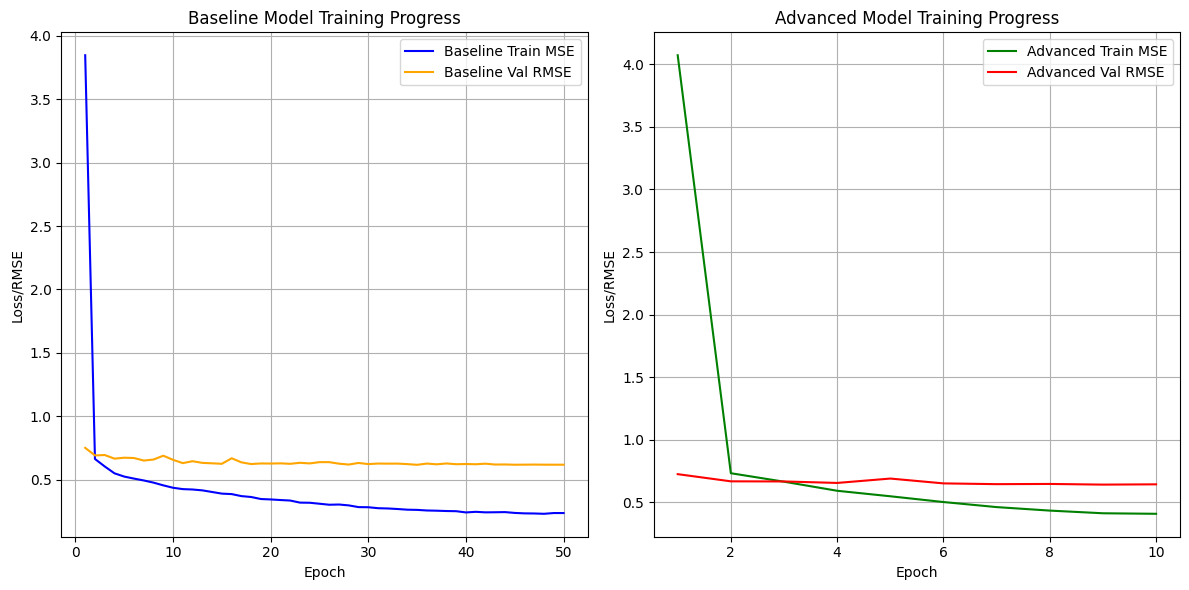

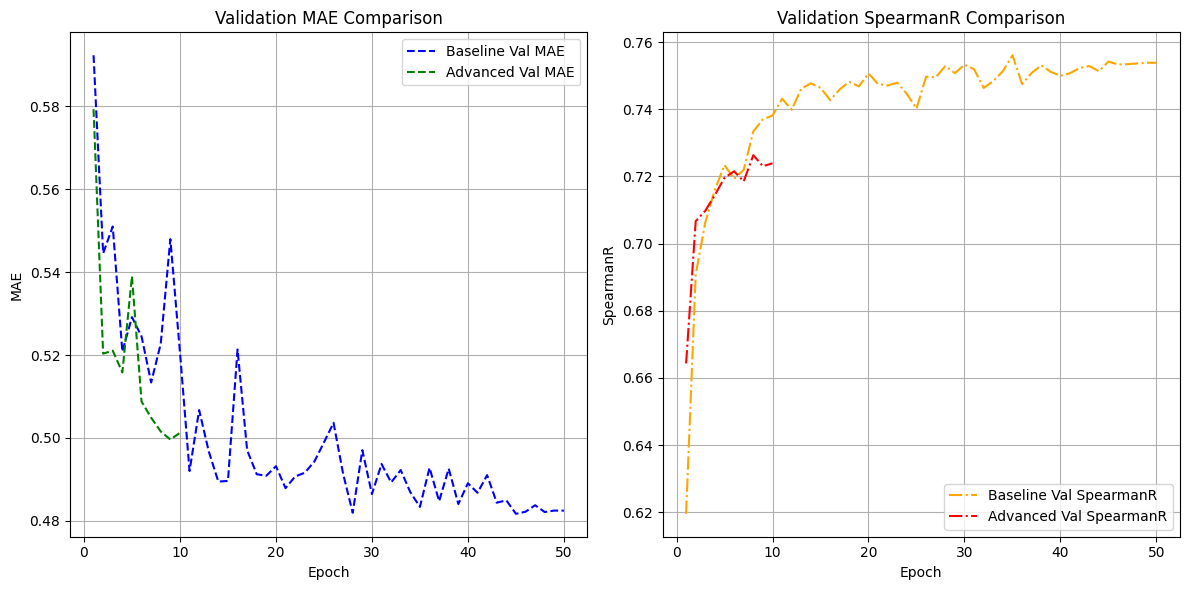

In [69]:
# -------------------------
# Plotting Training Progress
# -------------------------

# Plot training loss and validation RMSE for Baseline
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(range(1, len(baseline_train_losses) + 1), baseline_train_losses, label='Baseline Train MSE', color='blue')
plt.plot(range(1, len(baseline_val_metrics_df) + 1), baseline_val_metrics_df['RMSE'], label='Baseline Val RMSE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss/RMSE')
plt.title('Baseline Model Training Progress')
plt.legend()
plt.grid(True)

# Plot training loss and validation RMSE for Advanced
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(range(1, len(advanced_train_losses) + 1), advanced_train_losses, label='Advanced Train MSE', color='green')
plt.plot(range(1, len(advanced_val_metrics_df) + 1), advanced_val_metrics_df['RMSE'], label='Advanced Val RMSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss/RMSE')
plt.title('Advanced Model Training Progress')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot other validation metrics for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # MAE Comparison
plt.plot(range(1, len(baseline_val_metrics_df) + 1), baseline_val_metrics_df['MAE'], label='Baseline Val MAE', color='blue', linestyle='--')
plt.plot(range(1, len(advanced_val_metrics_df) + 1), advanced_val_metrics_df['MAE'], label='Advanced Val MAE', color='green', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # SpearmanR Comparison
plt.plot(range(1, len(baseline_val_metrics_df) + 1), baseline_val_metrics_df['SpearmanR'], label='Baseline Val SpearmanR', color='orange', linestyle='-.')
plt.plot(range(1, len(advanced_val_metrics_df) + 1), advanced_val_metrics_df['SpearmanR'], label='Advanced Val SpearmanR', color='red', linestyle='-.')
plt.xlabel('Epoch')
plt.ylabel('SpearmanR')
plt.title('Validation SpearmanR Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
# -------------------------
# Final Performance Comparison Table
# -------------------------

# Get the best metrics for each model (based on lowest RMSE)
best_baseline_metrics = baseline_val_metrics_df.loc[baseline_val_metrics_df['RMSE'].idxmin()]
best_advanced_metrics = advanced_val_metrics_df.loc[advanced_val_metrics_df['RMSE'].idxmin()]

comparison_data = {
    'Metric': ['MAE', 'RMSE', 'SpearmanR'],
    'Baseline Model': [best_baseline_metrics['MAE'], best_baseline_metrics['RMSE'], best_baseline_metrics['SpearmanR']],
    'Advanced Model': [best_advanced_metrics['MAE'], best_advanced_metrics['RMSE'], best_advanced_metrics['SpearmanR']]
}

comparison_df = pd.DataFrame(comparison_data)

print("Final Model Performance Comparison (Best Epoch):")
display(comparison_df)

Final Model Performance Comparison (Best Epoch):


,Metric,Baseline Model,Advanced Model
0,MAE,0.483376,0.499628
1,RMSE,0.618519,0.641851
2,SpearmanR,0.756103,0.723046
